# Handwritten Signature Classification

## Forged Vs. Real

## Objectives

This capability demonstration trains a deep learning model to analyze handwritten signatures and clssify them as real or forged. The dataset allows two possible targets, determining forgery or determining the author. This initial demonstration targets forgery.   

__Possible Model Targets__

1. Detect forged v. real signatures.
  - target: one-hot encoded forged (1) and real (0) signatures. The targets were chosen as 1 for forged signatures and 0 for real signatures.
  
2. Detect the identity of the signer. 
- target: author id. a future iteration of this demonstration will attempt to identify one particular author from the entire set.

## Workflow

1. Collect a data set and determine model objectives
2. Load and prepare the data set and set targets in the data
3. Build the model
4. Train the model
5. Evaluate the model
6. Determine model enhancements and repeat

All ML development workflows follow a similar pattern. When the model works sufficiently to meet production requirements, the model would be integrated into a pipeline to enable infernetial request through an API or other software service.  

---

### 1. Data Sourcing

__Source__
- Kaggle Signature_Verification_Dataset containing signatures of Dutch Users for checking forgery
- https://www.kaggle.com/robinreni/signature-verification-dataset

__Context__
- This dataset contains multiple signature images of dutch users, both genuine and fraudulent.

__Content__
- In the dataset the directory number contains an id for the user and a directory path name indicating whether the signatures in the directory are forged. Geniune signature images just have the user id in the path name, fraudulent signatures have a suffix of `_forg`.
- The dataset is split between training and test sets in by the provider in two different parent directories. 

__Acknowledgements__
All the data are extracted from ICDAR 2011 Signature Dataset and organized perfectly for user usage.

https://www.kaggle.com/robinreni/signature-verification-dataset

### 2. Data Preparation

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import imageio
from PIL import Image
from pylab import imshow

In [2]:
!python --version

Python 3.7.7


In [3]:
data_root = "../sign_data/"
train_data_path = '../sign_data/train/'
test_data_path = '../sign_data/test/'

In [4]:
# training set
!ls "../sign_data/train/"

001      014      022      030      038      046      054      062
001_forg 014_forg 022_forg 030_forg 038_forg 046_forg 054_forg 062_forg
002      015      023      031      039      047      055      063
002_forg 015_forg 023_forg 031_forg 039_forg 047_forg 055_forg 063_forg
003      016      024      032      040      048      056      064
003_forg 016_forg 024_forg 032_forg 040_forg 048_forg 056_forg 064_forg
004      017      025      033      041      049      057      065
004_forg 017_forg 025_forg 033_forg 041_forg 049_forg 057_forg 065_forg
006      018      026      034      042      050      058      066
006_forg 018_forg 026_forg 034_forg 042_forg 050_forg 058_forg 066_forg
009      019      027      035      043      051      059      067
009_forg 019_forg 027_forg 035_forg 043_forg 051_forg 059_forg 067_forg
012      020      028      036      044      052      060      068
012_forg 020_forg 028_forg 036_forg 044_forg 052_forg 060_forg 068_forg
013      021      029      

In [5]:
# test set
!ls "../sign_data/test/"

049      052      055      058      061      064      067
049_forg 052_forg 055_forg 058_forg 061_forg 064_forg 067_forg
050      053      056      059      062      065      068
050_forg 053_forg 056_forg 059_forg 062_forg 065_forg 068_forg
051      054      057      060      063      066      069
051_forg 054_forg 057_forg 060_forg 063_forg 066_forg 069_forg


In [6]:
# create a convenient data structure 

def build_data_source_dict(path):
    """ traverse root directory and build a list of the targets and image file paths
        input: 
            path containing images. assumes all images are .png
        output: 
            dictionary of file path and targets of the form:
                {'../sign_data/train/020_forg/01_0127020.PNG': ['020', 1],
                 '../sign_data/train/020_forg/04_0101020.PNG': ['020', 1],
                 ... }
    """
    # result dict of files and attributes
    data = {}

    for root, dirs, files in os.walk(path):
        path = root.split(os.sep)

        print('\n' + root)

        uid = os.path.basename(root)[:3]
        forged = (1 if os.path.basename(root)[4:] == 'forg' else 0)

        print(f'uid = {uid}')
        print(f'forged = {forged}')

        for file in files:        
            filename, file_extension = os.path.splitext(file)
            if file_extension.lower() == '.png':
                print(os.path.join(root, file))
                data[os.path.join(root, file)] = [uid, forged]
                
    return data
            
train_data = build_data_source_dict("../sign_data/train/")

test_data = build_data_source_dict("../sign_data/test/")


../sign_data/train/
uid = 
forged = 0

../sign_data/train/020_forg
uid = 020
forged = 1
../sign_data/train/020_forg/01_0127020.PNG
../sign_data/train/020_forg/04_0101020.PNG
../sign_data/train/020_forg/04_0127020.PNG
../sign_data/train/020_forg/02_0105020.PNG
../sign_data/train/020_forg/02_0117020.PNG
../sign_data/train/020_forg/01_0117020.PNG
../sign_data/train/020_forg/01_0105020.PNG
../sign_data/train/020_forg/02_0101020.PNG
../sign_data/train/020_forg/03_0213020.PNG
../sign_data/train/020_forg/02_0127020.PNG
../sign_data/train/020_forg/04_0105020.PNG
../sign_data/train/020_forg/04_0117020.PNG
../sign_data/train/020_forg/03_0105020.PNG
../sign_data/train/020_forg/03_0117020.PNG
../sign_data/train/020_forg/01_0213020.PNG
../sign_data/train/020_forg/04_0213020.PNG
../sign_data/train/020_forg/03_0127020.PNG
../sign_data/train/020_forg/02_0213020.PNG
../sign_data/train/020_forg/03_0101020.PNG

../sign_data/train/036_forg
uid = 036
forged = 1
../sign_data/train/036_forg/02_0123036.PNG
.

../sign_data/train/012_forg/0206012_03.png
../sign_data/train/012_forg/0206012_02.png
../sign_data/train/012_forg/0113012_04.png
../sign_data/train/012_forg/0206012_01.png

../sign_data/train/069_forg
uid = 069
forged = 1
../sign_data/train/069_forg/02_0111069.PNG
../sign_data/train/069_forg/03_0108069.PNG
../sign_data/train/069_forg/01_0111069.PNG
../sign_data/train/069_forg/04_0111069.PNG
../sign_data/train/069_forg/03_0106069.PNG
../sign_data/train/069_forg/03_0111069.PNG
../sign_data/train/069_forg/04_0106069.PNG
../sign_data/train/069_forg/01_0108069.PNG
../sign_data/train/069_forg/04_0108069.PNG
../sign_data/train/069_forg/01_0106069.PNG
../sign_data/train/069_forg/02_0106069.PNG
../sign_data/train/069_forg/02_0108069.PNG

../sign_data/train/028_forg
uid = 028
forged = 1
../sign_data/train/028_forg/03_0212028.PNG
../sign_data/train/028_forg/04_0205028.PNG
../sign_data/train/028_forg/01_0205028.PNG
../sign_data/train/028_forg/02_0126028.PNG
../sign_data/train/028_forg/01_0126028.P

../sign_data/train/003_forg/0206003_03.png
../sign_data/train/003_forg/0126003_04.png
../sign_data/train/003_forg/0206003_01.png
../sign_data/train/003_forg/0126003_01.png
../sign_data/train/003_forg/0206003_04.png
../sign_data/train/003_forg/0126003_02.png
../sign_data/train/003_forg/0126003_03.png
../sign_data/train/003_forg/0121003_01.png
../sign_data/train/003_forg/0121003_03.png
../sign_data/train/003_forg/0121003_02.png
../sign_data/train/003_forg/0121003_04.png

../sign_data/train/023_forg
uid = 023
forged = 1
../sign_data/train/023_forg/03_0126023.PNG
../sign_data/train/023_forg/03_0203023.PNG
../sign_data/train/023_forg/04_0203023.PNG
../sign_data/train/023_forg/01_0126023.PNG
../sign_data/train/023_forg/04_0126023.PNG
../sign_data/train/023_forg/01_0203023.PNG
../sign_data/train/023_forg/02_0203023.PNG
../sign_data/train/023_forg/02_0126023.PNG

../sign_data/train/035_forg
uid = 035
forged = 1
../sign_data/train/035_forg/02_0115035.PNG
../sign_data/train/035_forg/01_0103035.P

../sign_data/test/059/11_059.png
../sign_data/test/059/08_059.png
../sign_data/test/059/03_059.png
../sign_data/test/059/02_059.png
../sign_data/test/059/12_059.png
../sign_data/test/059/07_059.png
../sign_data/test/059/06_059.png
../sign_data/test/059/04_059.png
../sign_data/test/059/05_059.png

../sign_data/test/050
uid = 050
forged = 0
../sign_data/test/050/04_050.png
../sign_data/test/050/05_050.png
../sign_data/test/050/07_050.png
../sign_data/test/050/06_050.png
../sign_data/test/050/03_050.png
../sign_data/test/050/12_050.png
../sign_data/test/050/02_050.png
../sign_data/test/050/09_050.png
../sign_data/test/050/10_050.png
../sign_data/test/050/11_050.png
../sign_data/test/050/01_050.png
../sign_data/test/050/08_050.png

../sign_data/test/057
uid = 057
forged = 0
../sign_data/test/057/05_057.png
../sign_data/test/057/04_057.png
../sign_data/test/057/06_057.png
../sign_data/test/057/07_057.png
../sign_data/test/057/12_057.png
../sign_data/test/057/02_057.png
../sign_data/test/057

In [7]:
# explore the csvs provided
train_data_df = pd.read_csv(os.path.join(data_root, "train_data.csv"), header=None)
train_data_df.head()

,0,1,2
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1


In [8]:
train_data_df.describe()

,2
count,23206.000000
mean,0.456951
std,0.498154
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
test_data_df = pd.read_csv(os.path.join(data_root, "test_data.csv"), header=None)
test_data_df.head()

,0,1,2
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1


In [10]:
test_data_df.describe()

,2
count,5748.000000
mean,0.517745
std,0.499728
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
# get unique file count
print(f'train data count: {len(set(train_data_df[0]) | set(train_data_df[1]))}')
print(f'test data count: {len(set(test_data_df[0]) | set(test_data_df[1]))}')

train data count: 1649
test data count: 500


#### Create Training and Test Data Sets

Need our X's and Y's as numpy arrays for training and testing. Generate numpy arrays of images and labels. Two types of arrays and two types of labels:

1. Xs as a) images as 2D arrays, with scaling as needed for CNN, and b) as flattened images for traditional ANN

2. Ys as labels for forged (1) or real (0), and for user_id

__Steps__

1. Parse the pandas dfs to create long-form pandas table of `[file_name, user_id, forged]`. The indices in the pandas table will correspond to the order of samples X and labels Y.

2. Create numpy arrays of image X's and labels Y, one array for users, and another with labels for forged


In [12]:
!ls "../sign_data/train/001/"

001_01.PNG 001_05.PNG 001_09.PNG 001_13.PNG 001_17.PNG 001_21.PNG
001_02.PNG 001_06.PNG 001_10.PNG 001_14.PNG 001_18.PNG 001_22.PNG
001_03.PNG 001_07.PNG 001_11.PNG 001_15.PNG 001_19.PNG 001_23.PNG
001_04.PNG 001_08.PNG 001_12.PNG 001_16.PNG 001_20.PNG 001_24.PNG


In [13]:
def plot_images(path, count=None):
    print(f'{path}')
    for root, dirs, files in os.walk(path):
        for f in files:
            img = mpimg.imread(f'{root}{f}')
            imgplot = plt.imshow(img)
            plt.show()

real uid: 001
../sign_data/train/001/


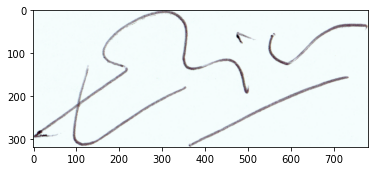

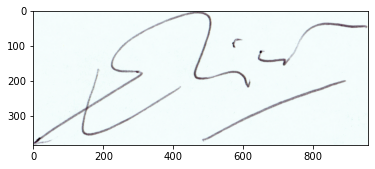

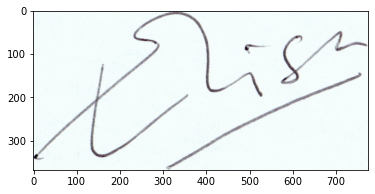

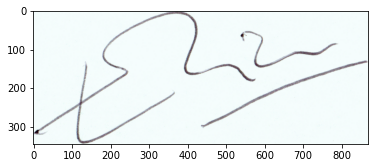

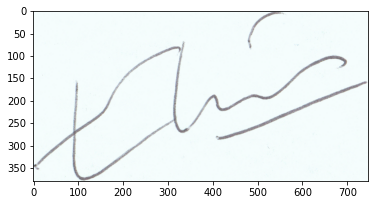

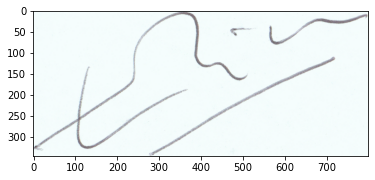

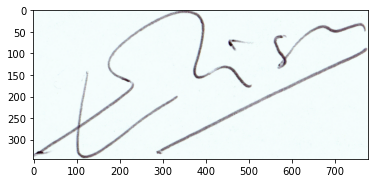

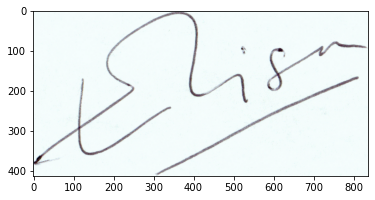

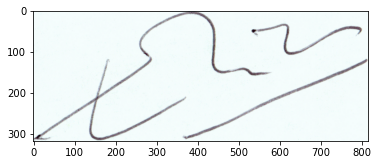

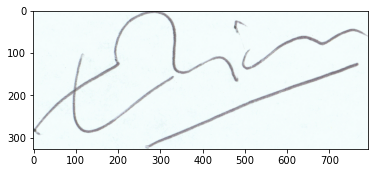

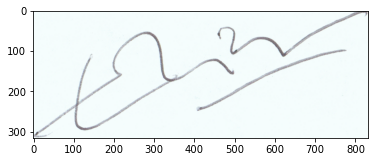

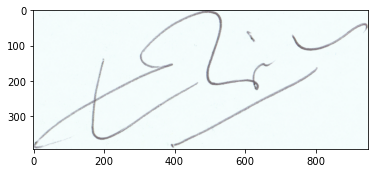

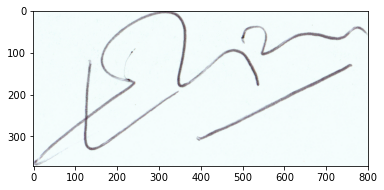

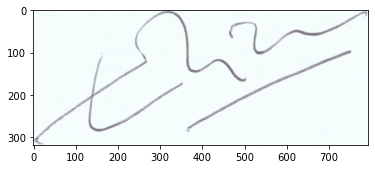

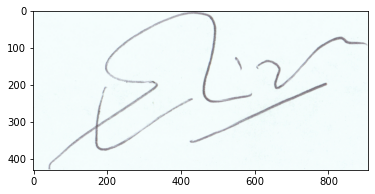

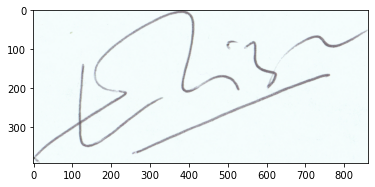

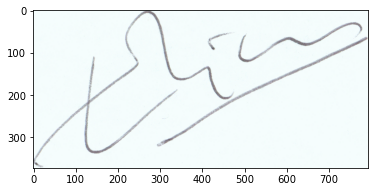

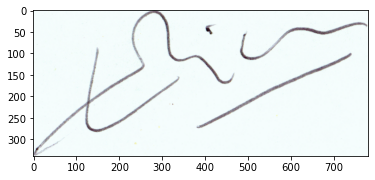

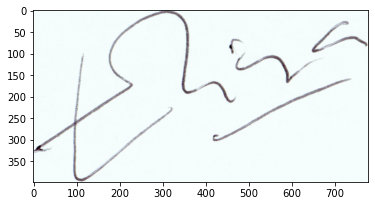

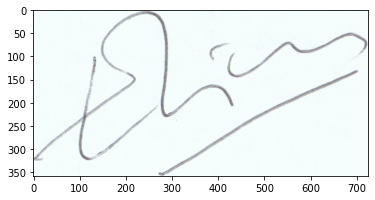

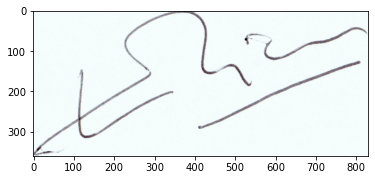

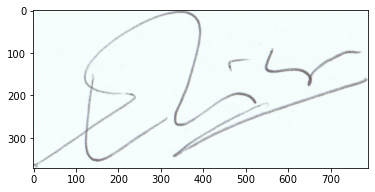

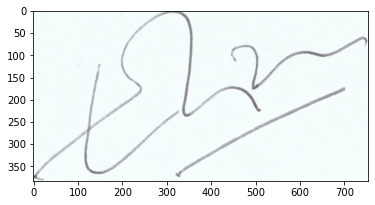

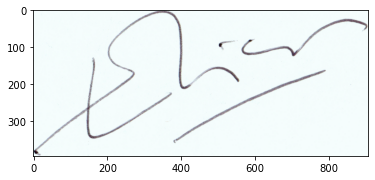

In [14]:
# real
uid = '001'

print(f'real uid: {uid}')

plot_images("../sign_data/train/001/")

forged
../sign_data/train/001_forg/


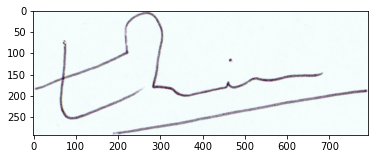

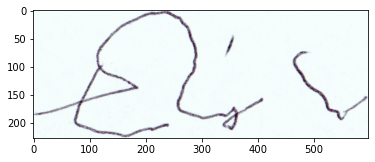

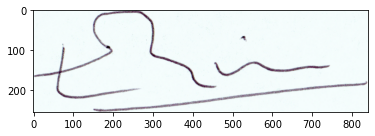

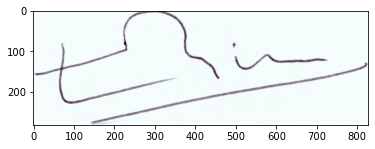

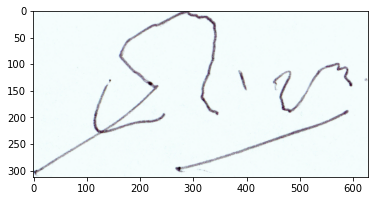

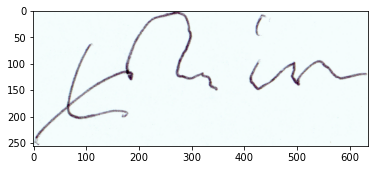

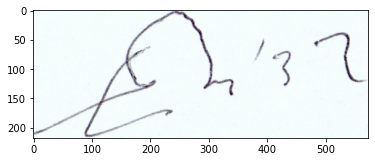

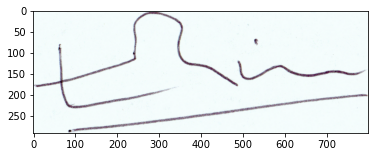

In [15]:
print(f'forged') 

plot_images('../sign_data/train/001_forg/')

In [16]:
def array_2d_from_image(img_path, x_sz, y_sz):
    """ returns a numpy array of size sz from a given image
        image is converted to B&W
    """
    try:
        im = Image.open(img_path).convert('L')
        
    except (OSError, IOError) as e:
        print(f"Could not read file {img_path} as image.")
        
    return np.array(im.resize((x_sz, y_sz)))
    

In [17]:
# test
im_sz = 64

array_2d_from_image("../sign_data/train/001_forg/0119001_01.png", im_sz, im_sz)

array([[251, 251, 251, ..., 251, 251, 251],
       [251, 251, 251, ..., 251, 251, 251],
       [251, 251, 251, ..., 251, 251, 251],
       ...,
       [164, 187, 252, ..., 251, 251, 251],
       [167, 248, 252, ..., 250, 251, 251],
       [237, 249, 251, ..., 250, 251, 251]], dtype=uint8)

In [18]:
# train_data, test_data

def build_data_sets(src_dict, size=32, flatten=False):
    """ build numpy data sets for modeling from dictionary of image sources and labels
    
        input:
        
        output:
            parallel numpy arrays of images and labels
            
        todo: change interface to emulate keras.datasets load_data()
    
    """
    X = []
    y = []

    for f in src_dict.keys():
        
        print(f'reading file: {f}')
        x = None
        
        # we are using the second key, boolean, for the label here
        print(f'label: {src_dict[f][1]}')
        
        y.append(int(src_dict[f][1]))
        
        # scale between 0 and 1
        x = array_2d_from_image(f, size, size).astype("float32") / 255
        x = np.expand_dims(x, -1)

        if flatten:
            X.append(x.flatten())

        else:
            X.append(x)
            
    return np.array(X), np.array(y)

In [19]:
X_train, y_train = build_data_sets(train_data, size=im_sz)
X_test, y_test = build_data_sets(test_data, size=im_sz)

reading file: ../sign_data/train/020_forg/01_0127020.PNG
label: 1
reading file: ../sign_data/train/020_forg/04_0101020.PNG
label: 1
reading file: ../sign_data/train/020_forg/04_0127020.PNG
label: 1
reading file: ../sign_data/train/020_forg/02_0105020.PNG
label: 1
reading file: ../sign_data/train/020_forg/02_0117020.PNG
label: 1
reading file: ../sign_data/train/020_forg/01_0117020.PNG
label: 1
reading file: ../sign_data/train/020_forg/01_0105020.PNG
label: 1
reading file: ../sign_data/train/020_forg/02_0101020.PNG
label: 1
reading file: ../sign_data/train/020_forg/03_0213020.PNG
label: 1
reading file: ../sign_data/train/020_forg/02_0127020.PNG
label: 1
reading file: ../sign_data/train/020_forg/04_0105020.PNG
label: 1
reading file: ../sign_data/train/020_forg/04_0117020.PNG
label: 1
reading file: ../sign_data/train/020_forg/03_0105020.PNG
label: 1
reading file: ../sign_data/train/020_forg/03_0117020.PNG
label: 1
reading file: ../sign_data/train/020_forg/01_0213020.PNG
label: 1
reading fi

reading file: ../sign_data/train/015/015_08.PNG
label: 0
reading file: ../sign_data/train/015/015_09.PNG
label: 0
reading file: ../sign_data/train/015/015_21.PNG
label: 0
reading file: ../sign_data/train/015/015_04.PNG
label: 0
reading file: ../sign_data/train/015/015_10.PNG
label: 0
reading file: ../sign_data/train/015/015_11.PNG
label: 0
reading file: ../sign_data/train/015/015_05.PNG
label: 0
reading file: ../sign_data/train/015/015_13.PNG
label: 0
reading file: ../sign_data/train/015/015_07.PNG
label: 0
reading file: ../sign_data/train/015/015_06.PNG
label: 0
reading file: ../sign_data/train/015/015_12.PNG
label: 0
reading file: ../sign_data/train/015/015_16.PNG
label: 0
reading file: ../sign_data/train/015/015_02.PNG
label: 0
reading file: ../sign_data/train/015/015_03.PNG
label: 0
reading file: ../sign_data/train/015/015_17.PNG
label: 0
reading file: ../sign_data/train/015/015_01.PNG
label: 0
reading file: ../sign_data/train/015/015_15.PNG
label: 0
reading file: ../sign_data/trai

reading file: ../sign_data/train/049/01_049.png
label: 0
reading file: ../sign_data/train/049/11_049.png
label: 0
reading file: ../sign_data/train/049/10_049.png
label: 0
reading file: ../sign_data/train/049/09_049.png
label: 0
reading file: ../sign_data/train/049/02_049.png
label: 0
reading file: ../sign_data/train/049/12_049.png
label: 0
reading file: ../sign_data/train/049/03_049.png
label: 0
reading file: ../sign_data/train/049/06_049.png
label: 0
reading file: ../sign_data/train/049/07_049.png
label: 0
reading file: ../sign_data/train/049/05_049.png
label: 0
reading file: ../sign_data/train/049/04_049.png
label: 0
reading file: ../sign_data/train/037_forg/02_0208037.PNG
label: 1
reading file: ../sign_data/train/037_forg/02_0123037.PNG
label: 1
reading file: ../sign_data/train/037_forg/02_0214037.PNG
label: 1
reading file: ../sign_data/train/037_forg/03_0114037.PNG
label: 1
reading file: ../sign_data/train/037_forg/04_0208037.PNG
label: 1
reading file: ../sign_data/train/037_forg/0

reading file: ../sign_data/train/051_forg/04_0120051.PNG
label: 1
reading file: ../sign_data/train/051_forg/04_0104051.PNG
label: 1
reading file: ../sign_data/train/051_forg/01_0120051.PNG
label: 1
reading file: ../sign_data/train/051_forg/01_0104051.PNG
label: 1
reading file: ../sign_data/train/051_forg/02_0104051.PNG
label: 1
reading file: ../sign_data/train/051_forg/02_0120051.PNG
label: 1
reading file: ../sign_data/train/036/06_036.png
label: 0
reading file: ../sign_data/train/036/07_036.png
label: 0
reading file: ../sign_data/train/036/05_036.png
label: 0
reading file: ../sign_data/train/036/04_036.png
label: 0
reading file: ../sign_data/train/036/08_036.png
label: 0
reading file: ../sign_data/train/036/11_036.png
label: 0
reading file: ../sign_data/train/036/01_036.png
label: 0
reading file: ../sign_data/train/036/10_036.png
label: 0
reading file: ../sign_data/train/036/09_036.png
label: 0
reading file: ../sign_data/train/036/12_036.png
label: 0
reading file: ../sign_data/train/0

reading file: ../sign_data/train/037/08_037.png
label: 0
reading file: ../sign_data/train/037/01_037.png
label: 0
reading file: ../sign_data/train/037/11_037.png
label: 0
reading file: ../sign_data/train/037/10_037.png
label: 0
reading file: ../sign_data/train/037/09_037.png
label: 0
reading file: ../sign_data/train/037/02_037.png
label: 0
reading file: ../sign_data/train/037/12_037.png
label: 0
reading file: ../sign_data/train/037/03_037.png
label: 0
reading file: ../sign_data/train/001/001_18.PNG
label: 0
reading file: ../sign_data/train/001/001_24.PNG
label: 0
reading file: ../sign_data/train/001/001_19.PNG
label: 0
reading file: ../sign_data/train/001/001_21.PNG
label: 0
reading file: ../sign_data/train/001/001_09.PNG
label: 0
reading file: ../sign_data/train/001/001_08.PNG
label: 0
reading file: ../sign_data/train/001/001_20.PNG
label: 0
reading file: ../sign_data/train/001/001_22.PNG
label: 0
reading file: ../sign_data/train/001/001_23.PNG
label: 0
reading file: ../sign_data/trai

reading file: ../sign_data/train/053_forg/04_0202053.PNG
label: 1
reading file: ../sign_data/train/053_forg/04_0207053.PNG
label: 1
reading file: ../sign_data/train/053_forg/03_0202053.PNG
label: 1
reading file: ../sign_data/train/053_forg/01_0207053.PNG
label: 1
reading file: ../sign_data/train/053_forg/02_0207053.PNG
label: 1
reading file: ../sign_data/train/053_forg/03_0107053.PNG
label: 1
reading file: ../sign_data/train/053_forg/03_0115053.PNG
label: 1
reading file: ../sign_data/train/045_forg/02_0111045.PNG
label: 1
reading file: ../sign_data/train/045_forg/04_0111045.PNG
label: 1
reading file: ../sign_data/train/045_forg/03_0205045.PNG
label: 1
reading file: ../sign_data/train/045_forg/01_0111045.PNG
label: 1
reading file: ../sign_data/train/045_forg/03_0116045.PNG
label: 1
reading file: ../sign_data/train/045_forg/04_0116045.PNG
label: 1
reading file: ../sign_data/train/045_forg/01_0205045.PNG
label: 1
reading file: ../sign_data/train/045_forg/04_0205045.PNG
label: 1
reading fi

reading file: ../sign_data/train/020/10_020.png
label: 0
reading file: ../sign_data/train/020/02_020.png
label: 0
reading file: ../sign_data/train/020/12_020.png
label: 0
reading file: ../sign_data/train/020/03_020.png
label: 0
reading file: ../sign_data/train/048_forg/02_0106048.PNG
label: 1
reading file: ../sign_data/train/048_forg/03_0204048.PNG
label: 1
reading file: ../sign_data/train/048_forg/04_0106048.PNG
label: 1
reading file: ../sign_data/train/048_forg/01_0106048.PNG
label: 1
reading file: ../sign_data/train/048_forg/02_0204048.PNG
label: 1
reading file: ../sign_data/train/048_forg/03_0106048.PNG
label: 1
reading file: ../sign_data/train/048_forg/04_0204048.PNG
label: 1
reading file: ../sign_data/train/048_forg/01_0204048.PNG
label: 1
reading file: ../sign_data/train/027/07_027.png
label: 0
reading file: ../sign_data/train/027/06_027.png
label: 0
reading file: ../sign_data/train/027/04_027.png
label: 0
reading file: ../sign_data/train/027/05_027.png
label: 0
reading file: ..

reading file: ../sign_data/train/013_forg/04_0113013.PNG
label: 1
reading file: ../sign_data/train/028/02_028.png
label: 0
reading file: ../sign_data/train/028/12_028.png
label: 0
reading file: ../sign_data/train/028/03_028.png
label: 0
reading file: ../sign_data/train/028/01_028.png
label: 0
reading file: ../sign_data/train/028/11_028.png
label: 0
reading file: ../sign_data/train/028/08_028.png
label: 0
reading file: ../sign_data/train/028/09_028.png
label: 0
reading file: ../sign_data/train/028/10_028.png
label: 0
reading file: ../sign_data/train/028/05_028.png
label: 0
reading file: ../sign_data/train/028/04_028.png
label: 0
reading file: ../sign_data/train/028/06_028.png
label: 0
reading file: ../sign_data/train/028/07_028.png
label: 0
reading file: ../sign_data/train/044_forg/03_0211044.PNG
label: 1
reading file: ../sign_data/train/044_forg/02_0103044.PNG
label: 1
reading file: ../sign_data/train/044_forg/03_0112044.PNG
label: 1
reading file: ../sign_data/train/044_forg/04_0103044

reading file: ../sign_data/train/061/03_061.png
label: 0
reading file: ../sign_data/train/061/06_061.png
label: 0
reading file: ../sign_data/train/061/07_061.png
label: 0
reading file: ../sign_data/train/061/05_061.png
label: 0
reading file: ../sign_data/train/061/04_061.png
label: 0
reading file: ../sign_data/train/063_forg/02_0108063.PNG
label: 1
reading file: ../sign_data/train/063_forg/02_0104063.PNG
label: 1
reading file: ../sign_data/train/063_forg/03_0119063.PNG
label: 1
reading file: ../sign_data/train/063_forg/01_0104063.PNG
label: 1
reading file: ../sign_data/train/063_forg/01_0108063.PNG
label: 1
reading file: ../sign_data/train/063_forg/04_0108063.PNG
label: 1
reading file: ../sign_data/train/063_forg/04_0104063.PNG
label: 1
reading file: ../sign_data/train/063_forg/02_0119063.PNG
label: 1
reading file: ../sign_data/train/063_forg/03_0108063.PNG
label: 1
reading file: ../sign_data/train/063_forg/03_0104063.PNG
label: 1
reading file: ../sign_data/train/063_forg/04_0119063.PN

reading file: ../sign_data/train/033/02_033.png
label: 0
reading file: ../sign_data/train/043_forg/03_0201043.PNG
label: 1
reading file: ../sign_data/train/043_forg/02_0111043.PNG
label: 1
reading file: ../sign_data/train/043_forg/03_0211043.PNG
label: 1
reading file: ../sign_data/train/043_forg/01_0111043.PNG
label: 1
reading file: ../sign_data/train/043_forg/04_0111043.PNG
label: 1
reading file: ../sign_data/train/043_forg/02_0211043.PNG
label: 1
reading file: ../sign_data/train/043_forg/03_0111043.PNG
label: 1
reading file: ../sign_data/train/043_forg/02_0201043.PNG
label: 1
reading file: ../sign_data/train/043_forg/01_0201043.PNG
label: 1
reading file: ../sign_data/train/043_forg/04_0211043.PNG
label: 1
reading file: ../sign_data/train/043_forg/01_0211043.PNG
label: 1
reading file: ../sign_data/train/043_forg/04_0201043.PNG
label: 1
reading file: ../sign_data/train/014_forg/0104014_02.png
label: 1
reading file: ../sign_data/train/014_forg/0208014_04.png
label: 1
reading file: ../si

reading file: ../sign_data/train/015_forg/0210015_01.png
label: 1
reading file: ../sign_data/train/042_forg/04_0107042.PNG
label: 1
reading file: ../sign_data/train/042_forg/04_0204042.PNG
label: 1
reading file: ../sign_data/train/042_forg/01_0204042.PNG
label: 1
reading file: ../sign_data/train/042_forg/01_0107042.PNG
label: 1
reading file: ../sign_data/train/042_forg/02_0107042.PNG
label: 1
reading file: ../sign_data/train/042_forg/02_0204042.PNG
label: 1
reading file: ../sign_data/train/042_forg/03_0118042.PNG
label: 1
reading file: ../sign_data/train/042_forg/04_0118042.PNG
label: 1
reading file: ../sign_data/train/042_forg/01_0118042.PNG
label: 1
reading file: ../sign_data/train/042_forg/02_0118042.PNG
label: 1
reading file: ../sign_data/train/042_forg/03_0204042.PNG
label: 1
reading file: ../sign_data/train/042_forg/03_0107042.PNG
label: 1
reading file: ../sign_data/train/054_forg/04_0208054.PNG
label: 1
reading file: ../sign_data/train/054_forg/01_0214054.PNG
label: 1
reading fi

reading file: ../sign_data/test/049/05_049.png
label: 0
reading file: ../sign_data/test/049/04_049.png
label: 0
reading file: ../sign_data/test/065/09_065.png
label: 0
reading file: ../sign_data/test/065/10_065.png
label: 0
reading file: ../sign_data/test/065/01_065.png
label: 0
reading file: ../sign_data/test/065/11_065.png
label: 0
reading file: ../sign_data/test/065/08_065.png
label: 0
reading file: ../sign_data/test/065/03_065.png
label: 0
reading file: ../sign_data/test/065/02_065.png
label: 0
reading file: ../sign_data/test/065/12_065.png
label: 0
reading file: ../sign_data/test/065/07_065.png
label: 0
reading file: ../sign_data/test/065/06_065.png
label: 0
reading file: ../sign_data/test/065/04_065.png
label: 0
reading file: ../sign_data/test/065/05_065.png
label: 0
reading file: ../sign_data/test/062/01_062.png
label: 0
reading file: ../sign_data/test/062/11_062.png
label: 0
reading file: ../sign_data/test/062/08_062.png
label: 0
reading file: ../sign_data/test/062/09_062.png
l

reading file: ../sign_data/test/053_forg/02_0207053.PNG
label: 1
reading file: ../sign_data/test/053_forg/03_0107053.PNG
label: 1
reading file: ../sign_data/test/053_forg/03_0115053.PNG
label: 1
reading file: ../sign_data/test/069_forg/02_0111069.PNG
label: 1
reading file: ../sign_data/test/069_forg/03_0108069.PNG
label: 1
reading file: ../sign_data/test/069_forg/01_0111069.PNG
label: 1
reading file: ../sign_data/test/069_forg/04_0111069.PNG
label: 1
reading file: ../sign_data/test/069_forg/03_0106069.PNG
label: 1
reading file: ../sign_data/test/069_forg/03_0111069.PNG
label: 1
reading file: ../sign_data/test/069_forg/04_0106069.PNG
label: 1
reading file: ../sign_data/test/069_forg/01_0108069.PNG
label: 1
reading file: ../sign_data/test/069_forg/04_0108069.PNG
label: 1
reading file: ../sign_data/test/069_forg/01_0106069.PNG
label: 1
reading file: ../sign_data/test/069_forg/02_0106069.PNG
label: 1
reading file: ../sign_data/test/069_forg/02_0108069.PNG
label: 1
reading file: ../sign_dat

reading file: ../sign_data/test/056/10_056.png
label: 0
reading file: ../sign_data/test/069/05_069.png
label: 0
reading file: ../sign_data/test/069/04_069.png
label: 0
reading file: ../sign_data/test/069/06_069.png
label: 0
reading file: ../sign_data/test/069/07_069.png
label: 0
reading file: ../sign_data/test/069/12_069.png
label: 0
reading file: ../sign_data/test/069/02_069.png
label: 0
reading file: ../sign_data/test/069/03_069.png
label: 0
reading file: ../sign_data/test/069/08_069.png
label: 0
reading file: ../sign_data/test/069/11_069.png
label: 0
reading file: ../sign_data/test/069/01_069.png
label: 0
reading file: ../sign_data/test/069/10_069.png
label: 0
reading file: ../sign_data/test/069/09_069.png
label: 0
reading file: ../sign_data/test/051/04_051.png
label: 0
reading file: ../sign_data/test/051/05_051.png
label: 0
reading file: ../sign_data/test/051/07_051.png
label: 0
reading file: ../sign_data/test/051/06_051.png
label: 0
reading file: ../sign_data/test/051/03_051.png
l

In [20]:
X_train.shape, y_train.shape

((1649, 64, 64, 1), (1649,))

In [21]:
X_test.shape, y_test.shape

((500, 64, 64, 1), (500,))

In [22]:
X_test[0]

array([[[0.98039216],
        [0.9647059 ],
        [0.98039216],
        ...,
        [0.9843137 ],
        [0.9843137 ],
        [0.9843137 ]],

       [[0.9764706 ],
        [0.96862745],
        [0.972549  ],
        ...,
        [0.9843137 ],
        [0.9843137 ],
        [0.9843137 ]],

       [[0.9764706 ],
        [0.96862745],
        [0.96862745],
        ...,
        [0.98039216],
        [0.9843137 ],
        [0.9843137 ]],

       ...,

       [[1.        ],
        [0.6627451 ],
        [0.7647059 ],
        ...,
        [0.9843137 ],
        [0.98039216],
        [0.9764706 ]],

       [[0.99607843],
        [0.8039216 ],
        [0.8745098 ],
        ...,
        [0.98039216],
        [0.98039216],
        [0.9764706 ]],

       [[0.98039216],
        [0.9529412 ],
        [0.972549  ],
        ...,
        [0.98039216],
        [0.9764706 ],
        [0.98039216]]], dtype=float32)

In [23]:
y_test[0]

1

image 1 label: 1


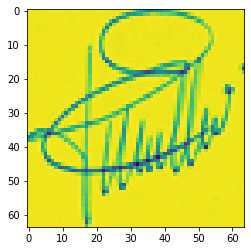

image 251 label: 0


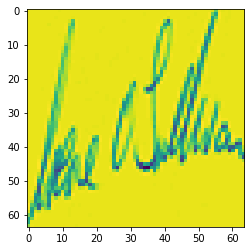

image 501 label: 1


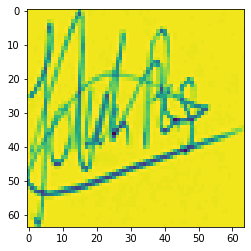

image 751 label: 1


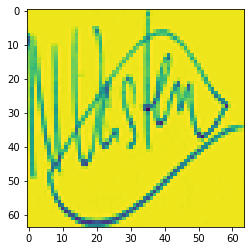

In [37]:
# visualize a few training images
for i in range(1, 1000, 250):
    print(f'image {i} label: {y_train[i]}')
    imshow(X_train[i].reshape(im_sz, im_sz))
    plt.show()

### 3.0 Build Model

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, Activation
from tensorflow.keras.utils import plot_model, to_categorical

# for model visualization
import pydot 
import graphviz
print(tf.__version__)

2.0.0


In [26]:
# Make sure images have shape (28, 28, 1)
# X_train = np.expand_dims(X_train, -1)
# X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (1649, 64, 64, 1)
1649 train samples
500 test samples


In [27]:
K = len(np.unique(y_train))
print(f'{K} labels')

print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

2 labels
y_train shape: (1649,)
y_test shape: (500,)


In [28]:
# Build the model
i = Input(shape=X_train[0].shape)
x = Conv2D(32, (3,3), strides=2, activation='relu')(i)
x = Conv2D(64, (3,3), strides=2, activation='relu')(x)
x = Conv2D(128, (3,3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(K, activation='softmax')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 31, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               321177

In [30]:
# Compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [31]:
# convert class vectors to binary class matrices
# num_classes = 2
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

# print(f'y_train shape: {y_train.shape}')

In [32]:
# Train the model
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30)

Train on 1649 samples, validate on 500 samples
Epoch 1/30
1649/1649 [==============================] - 4s 3ms/sample - loss: 0.7272 - accuracy: 0.5391 - val_loss: 0.6918 - val_accuracy: 0.5040
Epoch 2/30
1649/1649 [==============================] - 3s 2ms/sample - loss: 0.6964 - accuracy: 0.5252 - val_loss: 0.6904 - val_accuracy: 0.5040
Epoch 3/30
1649/1649 [==============================] - 3s 2ms/sample - loss: 0.6931 - accuracy: 0.5240 - val_loss: 0.6734 - val_accuracy: 0.5320
Epoch 4/30
1649/1649 [==============================] - 3s 2ms/sample - loss: 0.6700 - accuracy: 0.6113 - val_loss: 0.6522 - val_accuracy: 0.6180
Epoch 5/30
1649/1649 [==============================] - 3s 2ms/sample - loss: 0.6326 - accuracy: 0.6483 - val_loss: 0.6267 - val_accuracy: 0.6500
Epoch 6/30
1649/1649 [==============================] - 3s 2ms/sample - loss: 0.5668 - accuracy: 0.6962 - val_loss: 0.4927 - val_accuracy: 0.7640
Epoch 7/30
1649/1649 [==============================] - 3s 2ms/sample - loss:

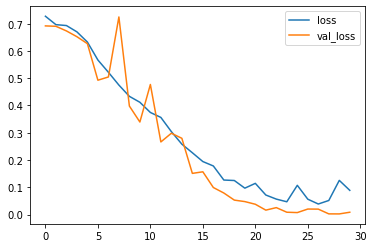

In [33]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

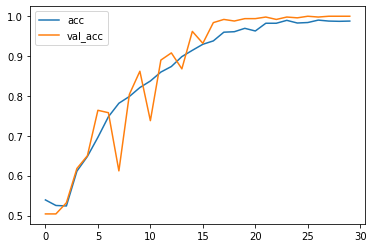

In [34]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

### 4. Evaluate the model

Good learning curves and convergence to near 100% accuracy during training

Image size set for faster model runs

Model converges more quickly for smaller image sizes

In [36]:
model.evaluate(X_test, y_test)

500/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.008682168141007423, 1.0]